In [1]:
import os
import numpy as np
from nilearn import plotting
import nibabel as nib
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

In [2]:
path = '/home/jupyter/ai_postgraduate_project/data/resized_dataset/imagesTr/pancreas_001.nii.gz'

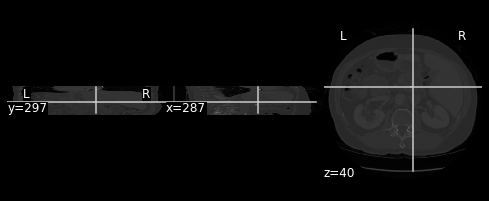

In [3]:
img = nib.load(path)
plotting.plot_anat(img)

In [4]:
np_array = np.array(img.dataobj)

In [5]:
new_image = nib.Nifti1Image(np_array, affine=np.eye(4))

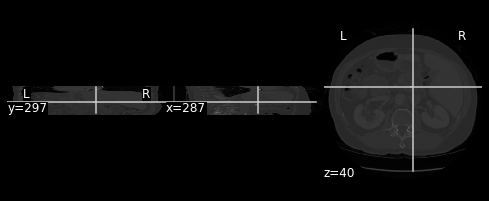

In [6]:
plotting.plot_anat(new_image)

In [14]:
def decide_to_apply(cond):
    
    """
    Decide whether to apply or not a condition
    
    Args:
        cond (bool): condition to be applied
    
    Returns:
        bool: whether to apply the input condition or not
    """
    
    decision = cond and np.random.random(1) > -1
    return decision


def random_flip(
    image, 
    target, 
    apply_flip_axis_x, 
    apply_flip_axis_y, 
    apply_flip_axis_z):
    
    """
    Randomly flip spatial dimensions
    
    Args:
        image (np.ndarray): image to be flipped
        target (np.ndarray): target to be flipped
        apply_flip_axis_x (bool): whether to flip x axis or not
        apply_flip_axis_y (bool): whether to flip y axis or not
        apply_flip_axis_z (bool): whether to flip z axis or not
    
    Returns:
        tuple: image and target flipped
    """
    
    apply_flip = [apply_flip_axis_x, apply_flip_axis_y, apply_flip_axis_z]

    for i in range(len(apply_flip)):
        if decide_to_apply(apply_flip[i]):
            print("Applying fip for axis " + str(i))
            image = np.flip(image, axis=i)
            target = np.flip(target, axis=i)
    
    return (image, target)
    

def add_gaussian_offset(image, apply_gaussian_offset, sigma):
    
    """
    Add Gaussian offset to an image. Adds the offset to each channel
    independently.
    
    Args:
        image (np.ndarray): image to add noise to
        apply_gaussian_offset (bool): whether to add Gaussian offset or not
        sigma (float): stddev of the Gaussian distribution to generate noise from
    
    Returns:
        np.ndarray: same as image but with added offset to each channel
    """
    
    if decide_to_apply(apply_gaussian_offset):
        print("Applying gaussian offset")
        offsets = np.random.normal(0, sigma, ([1] * (image.ndim - 1) + [image.shape[-1]]))
        image += offsets
    
    return image


def add_gaussian_noise(image, apply_gaussian_noise, sigma):
    
    """
    Add Gaussian noise to an image
    
    Args:
        image (np.ndarray): image to add noise to
        apply_gaussian_noise (bool): whether to add Gaussian noise or not
        sigma (float): stddev of the Gaussian distribution to generate noise from
    
    Returns:
        np.ndarray: same as image but with added offset to each channel
    """
 
    if decide_to_apply(apply_gaussian_noise):
        print("Applying noise")
        noise = np.random.normal(0, sigma, image.shape)
        image += noise
        
    return image

def elastic_transform(image, target, apply_elastic_transfor, alpha, sigma):
    
    """
    
    Elastic deformation of images as described in [1].
    [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
        Neural Networks applied to Visual Document Analysis", in Proc. of the
        International Conference on Document Analysis and Recognition, 2003.
    Based on gist https://gist.github.com/erniejunior/601cdf56d2b424757de5
    
    Args:
        image (np.ndarray): image to be deformed
        target (np.ndarray) : target to be deformed
        apply_elastic_transfor (bool): whether to apply elastic transformation or not
        alpha (list): scale of transformation for each dimension, where larger
            values have more deformation
        sigma (list): Gaussian window of deformation for each dimension, where
            smaller values have more localised deformation
    
    Returns:
        tuple: deformed image and deformed target
    """

    assert len(alpha) == len(sigma), "Dimensions of alpha and sigma are different for elastic transform"
    
    if decide_to_apply(apply_elastic_transfor):
        print("Applying elastic transformation")
        channelbool = image.ndim - len(alpha)
        out = np.zeros((len(alpha) + channelbool, ) + image.shape)

        # Generate a Gaussian filter, leaving channel dimensions zeroes
        for jj in range(len(alpha)):
            array = (np.random.rand(*image.shape) * 2 - 1)
            out[jj] = gaussian_filter(
                array, 
                sigma[jj],
                mode="constant", 
                cval=0) * alpha[jj]

        # Map mask to indices
        shapes = list(map(lambda x: slice(0, x, None), image.shape))
        grid = np.broadcast_arrays(*np.ogrid[shapes])
        indices = list(map((lambda x: np.reshape(x, (-1, 1))), grid + np.array(out)))

        # Transform image based on masked indices
        transformed_image = map_coordinates(
            image, 
            indices, 
            order=0,
            mode='reflect').reshape(image.shape)
        
        transformed_target = map_coordinates(
            target, 
            indices, 
            order=0,
            mode='reflect').reshape(target.shape)

       
    else:
        transformed_image = image
        transformed_target = target

    return (transformed_image, transformed_target)
    
    
def apply_transformations(
    image,
    target,
    apply_flip_axis_x = True,
    apply_flip_axis_y = True,
    apply_flip_axis_z = False,
    apply_gaussian_offset = True,
    apply_gaussian_noise = True,
    apply_elastic_transfor = True,
    sigma_gaussian_offset = 0.1,
    sigma_gaussian_noise = 0.05,
    alpha_elastic = [0,0,0],
    sigma_elastic = [1,1,1] 
):
    
    """
    Apply some transformation in order to have data augmentation
    
    Args:
        image (np.ndarray): image to apply transformations to
        target (np.ndarray): target to apply transformations to
        apply_flip_axis_x (bool): whether to flip x axis or not
        apply_flip_axis_y (bool): whether to flip y axis or not
        apply_flip_axis_z (bool): whether to flip z axis or not
        apply_gaussian_offset (bool): whether to add Gaussian offset or not
        apply_gaussian_noise (bool): whether to add Gaussian noise or not
        apply_elastic_transfor (bool): whether to apply elastic transformation or not
        sigma_gaussian_offset (bool): stddev of the Gaussian distribution to generate noise from
        sigma_gaussian_noise (bool): stddev of the Gaussian distribution to generate noise from
        alpha_elastic (bool): scale of transformation for each dimension, where larger
            values have more deformation
        sigma_elastic (bool): Gaussian window of deformation for each dimension, where
            smaller values have more localised deformation
    
    Returns:
        tuple: image and target with the transformation applied
    """
    
    assert image.shape == target.shape, "Image and target have different shapes"
    
    image = image.astype(float)
    target = target.astype(float)
    image, target = random_flip(image, target, apply_flip_axis_x, apply_flip_axis_y, apply_flip_axis_z)
    image = add_gaussian_offset(image, apply_gaussian_offset, sigma = sigma_gaussian_offset)
    image = add_gaussian_noise(image, apply_gaussian_noise, sigma = sigma_gaussian_noise)
    image, target = elastic_transform(image, target, apply_elastic_transfor, alpha = alpha_elastic, sigma = sigma_elastic)
    
    image = image.astype(np.float32)
    target = target.astype(np.float32)
    
    return (image, target)

Applying fip for axis 0
Applying fip for axis 1
Applying gaussian offset
Applying noise
Applying elastic transformation


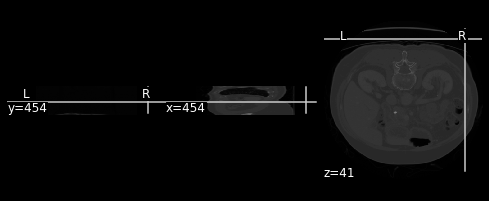

In [15]:
array_flip = apply_transformations(np_array, np_array, apply_elastic_transfor = True)
new_image = nib.Nifti1Image(array_flip[0], affine=np.eye(4))
plotting.plot_anat(new_image)

dtype('float32')